# Firm Entry and Exit - Week 4 - OSE Lab
## Thomas Pellet
### 07/2019

# Define the recursive eq


As in Khan & Thomas (2009), it is possible to define a recursive equilibrium for the model. This equilibrium consists of four conditions:
* Firms maximize their value given households preferences (Stochastic discount factor pricing contingent claims). In other words, we have that
<p align="center">
$\frac{1}{1+r} = \beta \frac{C_{t+1}}{C_t} $
</p>
* The free entry condition holds, so that incumbent firms are at least indifferent between entering the market with zero capital or staying out. 
<p align="center">
$c_{e} \leq \int v(\varepsilon, 0) \nu(d \varepsilon)$
</p>
* The labor and goods market clears: 
<p align="center">
$N(z, g)=\int n(\varepsilon, k ; z, g) g(\varepsilon, k) d \varepsilon d k$
</p>
<p align="center">
$C(z, g)=\int y(\varepsilon, k ; z, g)  - i(\varepsilon, k ; z, g) d \varepsilon d k$
</p>
* The distribution of active firms $g^*(\epsilon,k)$ is stationary

#  Compute Representative Agent Steady State

In [79]:
'''
The Representative agent steady state is defined by a system of 6 equations 
The 6 unknowns are
- r interest rate
- w wage rate
- K capital
- N labor --> assumed known so far
- C consumption
- Y production
- Π profit 

In reality, once we've solved for K, all other variables can be computed
'''
### HH FOC

'''
Background Equations: 
$U(C) = np.log(C - a*N)$
$C = W_N + Π$
$Π = Y - I - AC$
$C = W*N + exp(ϵ)* K**θ * N**ν - (δ*K) - (ϕ/2)*(δ**2)*K$

$E_HH = FOC U(C) wrt K$

$E_HH = (θ*N**ν*K**(θ-1) - δ - (ϕ/2)*δ**2) / ( \
        w*N + K**θ*N**ν - δ*K - (ϕ/2)*δ**2*K) = 0$
'''

# Set parameters
δ = 0.1
ϕ = 0.5
ν = 0.64
N = 0.6
θ = 0.21


#Important equation:
#E_HH = lambda K, N : K - (δ*(1+ϕ/2*δ)*N**(-ν)*ϕ**(-1))**(1/(θ-1))
Kf = lambda N: (δ*(1+ϕ/2*δ)*N**(-ν)*ϕ**(-1))**(1/(θ-1))
K = Kf(N)

### Production
Yf = lambda K, N : K**θ * N**ν

### Firms' FOC
wf = lambda K, N : ν*K**θ * N**(ν-1)
rf = lambda K, N : θ*K**(θ-1) + N**ν

### Profits
Π = lambda K, N: Yf(K,N) - wf(K, N)*N - (δ*K) - (ϕ/2)*δ**2 * K 

### Consumption
C = lambda K, N:   wf(K, N)*N + Π(K, N)

### LOM K at the SS
#Kp = K
AC = lambda K: -ϕ/2*(δ)**2*K


In [80]:
print("C is ", C(K, N))
print("K is ", K)
print("w is", wf(K,N))
print("Y is ", Yf(K, N))
print("Y - I - AC is", Yf(K, N) - δ*K + AC(K))

Krep = K
Nrep = N
wrep = wf(Krep, Nrep)
Vrep = Π(Krep, Nrep) 

C is  0.5037278240321985
K is  4.914417795436083
w is 1.074619357935357
Y is  1.007455648064397
Y - I - AC is 0.5037278240321985


# Solve for Incumbent Firms' Decision Rules

In [104]:
# Define Parameters in the model

θ, ν, δ, β, ϕ, Nrep, Nϵ, cf = .21, .64, .1, 96, .5, .6, 10, 0.01
#Tauchen parameters
ρ,μ,σ =.9,0,.02




# Production function
def prod(ϵ, k, n):
    if k > 0:
        return np.exp(ϵ) * k**θ * n**ν
    else:
        return -50000000


# LOM capital 
LOM_k = lambda k, i: (1-δ)*k + i

# Wages
w_f     = lambda ϵ, k, n: ν * np.exp(ϵ) * k**θ * n**(ν-1)

# Interest rate
r_f     = lambda ϵ, k, n: θ * np.exp(ϵ) * k**(θ-1) * n**ν

# Profits
Π     = lambda y, kp, k, n, w: y - w*n - (kp - (1 - δ)*k) - 0.5*ϕ * \
        (kp/k - (1-δ))**2*k

#Budget constraint
BC    = lambda c, w, n, Π: c - Π - w*n

#Goods constraint


# Utility function
def Uprime(c):
    if c > 0:
        return 1/c
    else:
        return 50000000

# Constraint for Capital savings 

cons = ({'type': 'ineq', 'fun': lambda x:  30 - x},
       {'type': 'ineq', 'fun': lambda x:  x})

In [117]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 20
tol, epsi, maxiter =1e-8,1, 1000

### State space K
Kmin=4.5
Kmax=5.3
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span
print(A)
# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t= interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def getValue1(prod, Uprime, interpolant, Kgrid, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep):
    
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(x,Kgrid,Vp[:,i])
        
    FutureVal = np.sum(exp)  
    
    Y         = prod(A[l], Kgrid[j], Nrep)
#     W         = w_f(A[l], Kgrid, Nrep)
    R         = r_f(A[l], Kgrid[j], Nrep)
    profit    = Π(Y, x, Kgrid[j], Nrep, W)
    V         = profit + FutureVal
    
    return V




#Equation 1 in Pbset
def exitchoice(Kgrid,getValue1, prod, Uprime, interpolant, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep, cf):
    # Simple exit payoff
    exitpayoff = (1-δ)*Kgrid[j]
    
    #Compute staying in market payoff
    Value1_at_x  = lambda x: getValue1(prod, Uprime, interpolant, Kgrid, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep)
    staypayoff = Value1_at_x(x) - cf
#     print("l index = ",l)
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        return -staypayoff




iter= 0
Vp=Krep*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    for j in range(sizeK):
        print('Grid point number ', j)
        
        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            exit_x = lambda x: exitchoice(Kgrid,getValue1, prod, Uprime, interpolant, Vp, x, j, l, A, P, Π, wrep, r_f, Nϵ, Nrep, cf)
            solve = minimize(exit_x,Kp[j,l], constraints=cons) #constraints=cons
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun

    epsi = np.sum(np.abs(Kp_new-Kp))
    print("Error term: ", epsi)
    if epsi < tol:
        break
        
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1

[-0.09176629 -0.07137378 -0.05098127 -0.03058876 -0.01019625  0.01019625
  0.03058876  0.05098127  0.07137378  0.09176629]
Grid point number  0
Grid point number  1
Grid point number  2
Grid point number  3
Grid point number  4
Grid point number  5
Grid point number  6
Grid point number  7
Grid point number  8
Grid point number  9
Grid point number  10
Grid point number  11
Grid point number  12
Grid point number  13
Grid point number  14
Grid point number  15
Grid point number  16
Grid point number  17
Grid point number  18
Grid point number  19
Error term:  982.8835590872163
Grid point number  0
Grid point number  1
Grid point number  2
Grid point number  3
Grid point number  4
Grid point number  5
Grid point number  6
Grid point number  7
Grid point number  8
Grid point number  9
Grid point number  10
Grid point number  11
Grid point number  12
Grid point number  13
Grid point number  14
Grid point number  15
Grid point number  16
Grid point number  17
Grid point number  18
Grid poi

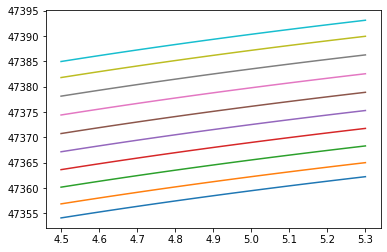

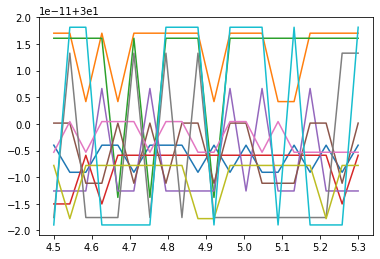

In [118]:
for i in range(Nϵ):
    plt.plot(Kgrid, Vp[:,i])
plt.show()

for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])
plt.show()

